In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score


sns.set(style="whitegrid")

In [2]:
# Crypto data
btc = pd.read_csv("../data/bitcoin_hourly.csv")
eth = pd.read_csv("../data/ethereum_hourly.csv")
sol = pd.read_csv("../data/solana_hourly.csv")

# Stock data
aapl = pd.read_csv("../data/AAPL_data.csv")
googl = pd.read_csv("../data/GOOGL_data.csv")
msft = pd.read_csv("../data/MSFT_data.csv")

btc["Timestamp"] = pd.to_datetime(btc["Timestamp"], unit="ms")
eth["Timestamp"] = pd.to_datetime(eth["Timestamp"], unit="ms")
sol["Timestamp"] = pd.to_datetime(sol["Timestamp"], unit="ms")

aapl["Date"] = pd.to_datetime(aapl["Date"])
googl["Date"] = pd.to_datetime(googl["Date"])
msft["Date"] = pd.to_datetime(msft["Date"])


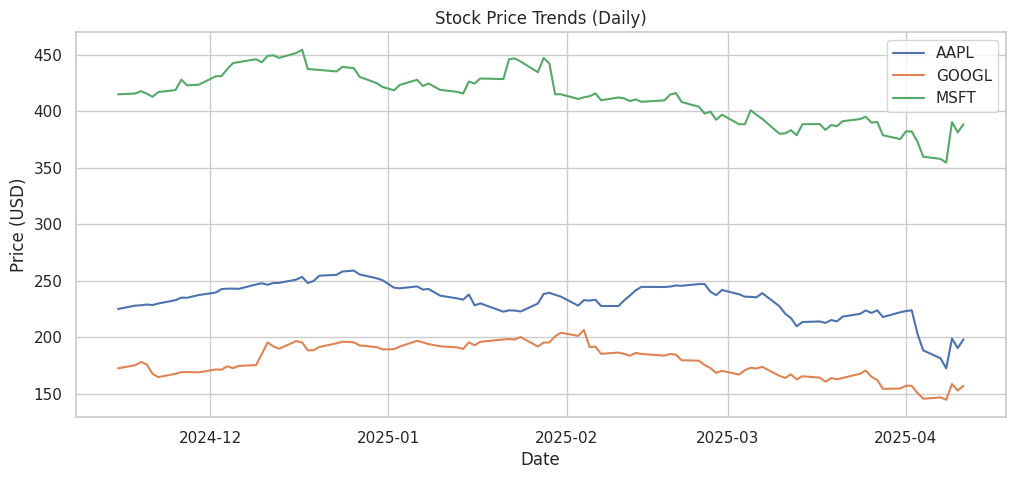

In [25]:
# Plot all 3 stocks' Close prices over time
plt.figure(figsize=(12, 5))
sns.lineplot(data=aapl, x="Date", y="Close", label="AAPL")
sns.lineplot(data=googl, x="Date", y="Close", label="GOOGL")
sns.lineplot(data=msft, x="Date", y="Close", label="MSFT")
plt.title("Stock Price Trends (Daily)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.show()


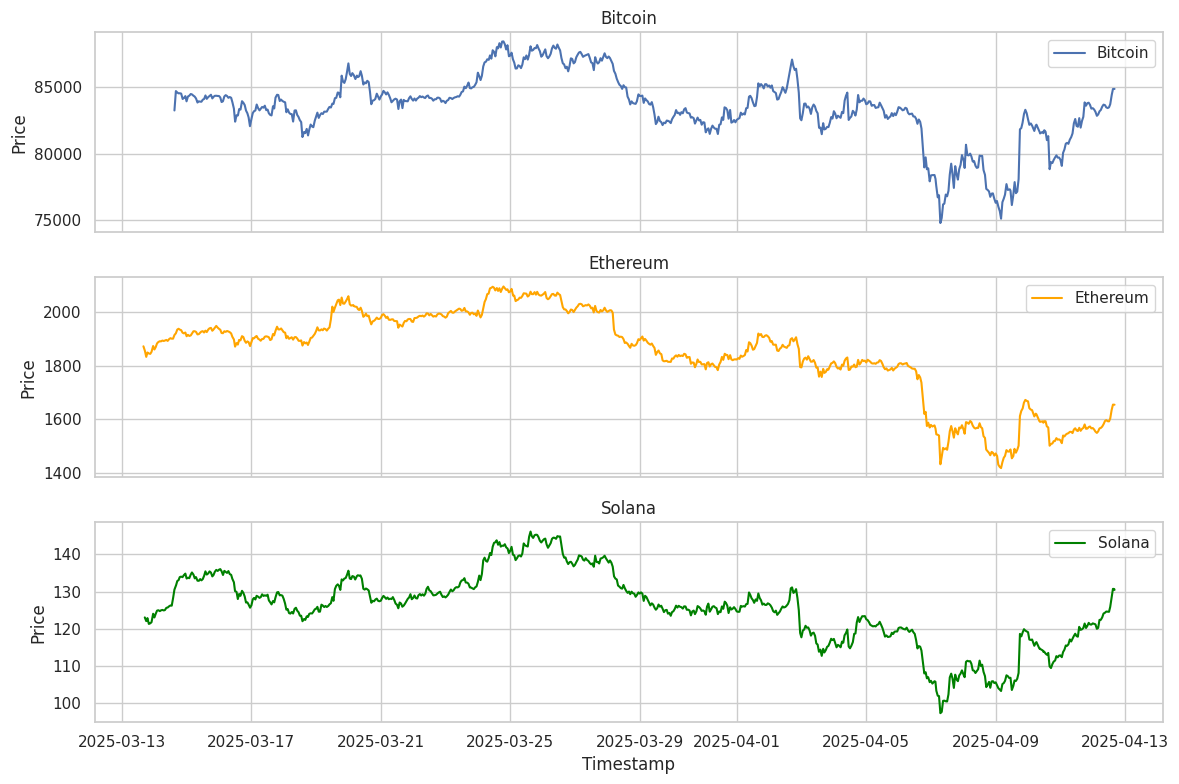

In [14]:
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

sns.lineplot(ax=axes[0], data=btc, x="Timestamp", y="Price", label="Bitcoin")
axes[0].set_title("Bitcoin")

sns.lineplot(ax=axes[1], data=eth, x="Timestamp", y="Price", label="Ethereum", color="orange")
axes[1].set_title("Ethereum")

sns.lineplot(ax=axes[2], data=sol, x="Timestamp", y="Price", label="Solana", color="green")
axes[2].set_title("Solana")

plt.tight_layout()
plt.show()


In [15]:
btc["price_change"] = btc["Price"].pct_change()
btc["rolling_avg"] = btc["Price"].rolling(window=24).mean()
btc["volatility"] = btc["Price"].rolling(window=24).std()


In [16]:
# Example: Ridge Regression for price prediction
btc = btc.dropna()
X = btc[["rolling_avg", "volatility"]]
y = btc["Price"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = Ridge()
model.fit(X_train, y_train)
preds = model.predict(X_test)

mse = mean_squared_error(y_test, preds)
print("MSE:", mse)


MSE: 1613306.7476989776


In [23]:
# Binary classification: Predict if BTC price will go UP (1) or DOWN (0)

# Create target column
btc["target"] = (btc["Price"].shift(-1) > btc["Price"]).astype(int)

# Drop NA rows
btc_clean = btc.dropna(subset=["rolling_avg", "volatility", "target"])

# Features and target
X = btc_clean[["rolling_avg", "volatility"]]
y = btc_clean["target"]

# Split and train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate
preds = rf.predict(X_test)
acc = accuracy_score(y_test, preds)

print("Random Forest Accuracy:", acc)


Random Forest Accuracy: 0.4740740740740741


We used two different machine learning models to explore the predictability of short-term Bitcoin price movements:

- **Ridge Regression** was applied to predict the exact price using `rolling_avg` and `volatility`. The model achieved a mean squared error (MSE) of 1,613,306.75. While the error is relatively high, it still captures some general trends in short-term price movement and demonstrates that linear models can extract value from technical indicators.

- **Random Forest Classifier** was used to predict whether the price would go **up or down** in the next time step. This model achieved an accuracy of approximately **47%**, which is slightly below random guessing. This result highlights the difficulty of short-term direction prediction in cryptocurrency markets, especially with only two basic technical indicators.

Together, these models demonstrate that machine learning can extract patterns in price behavior — but also reveal the limitations of using simple features in a noisy, highly volatile environment like crypto. With additional features such as momentum, volume surges, or external sentiment data, predictive performance could likely be improved.



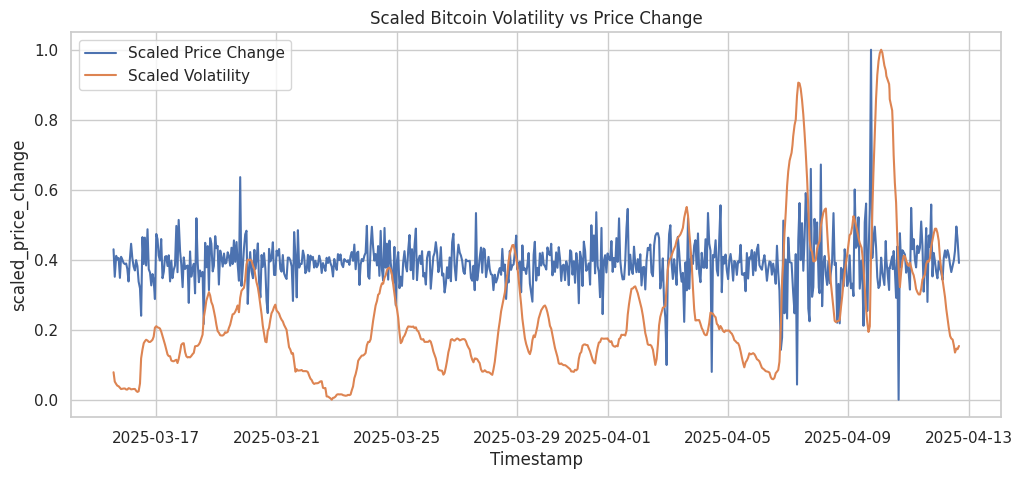

In [17]:
from sklearn.preprocessing import MinMaxScaler

# Scale both columns to 0–1 range
scaler = MinMaxScaler()
btc_scaled = btc[["price_change", "volatility"]].dropna()
scaled_values = scaler.fit_transform(btc_scaled)
btc[["scaled_price_change", "scaled_volatility"]] = scaled_values

plt.figure(figsize=(12, 5))
sns.lineplot(data=btc, x="Timestamp", y="scaled_price_change", label="Scaled Price Change")
sns.lineplot(data=btc, x="Timestamp", y="scaled_volatility", label="Scaled Volatility")
plt.title("Scaled Bitcoin Volatility vs Price Change")
plt.legend()
plt.show()



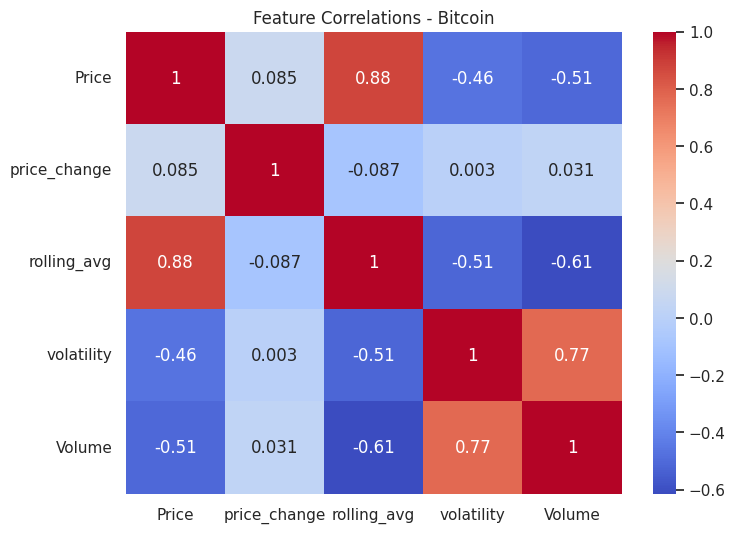

In [10]:

# Q2: Which financial indicators correlate with price spikes?
# Let's visualize correlations between price-related features for Bitcoin

btc["Volume"] = btc["Volume"].astype(float)  # Ensure Volume is numeric
plt.figure(figsize=(8, 6))
sns.heatmap(btc[["Price", "price_change", "rolling_avg", "volatility", "Volume"]].corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlations - Bitcoin")
plt.show()


### Q2 Answer: Indicators Correlated with Price Spikes

The heatmap shows that `rolling_avg` and `volatility` are strongly correlated with price. Volume shows weaker correlation, which might reflect BTC trading stability. These relationships help us choose features for prediction and identify possible early signals of movement.


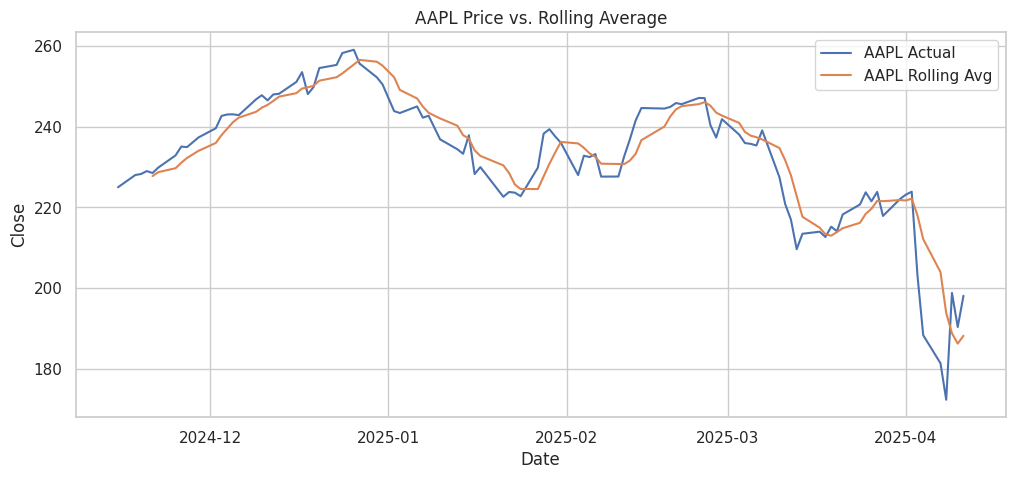

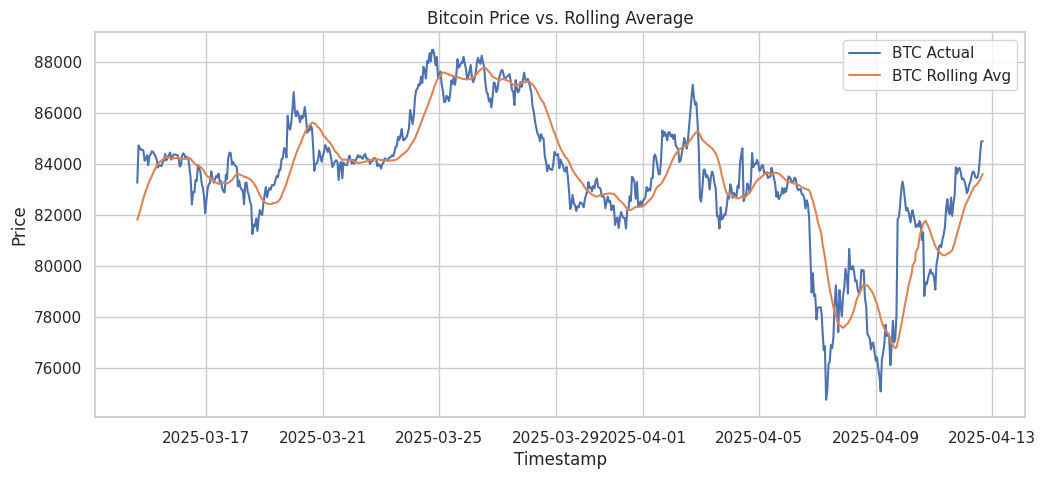

In [11]:
# Q3: How do prices react to broader market trends?
# Compare rolling averages of AAPL and BTC

aapl["rolling_avg"] = aapl["Close"].rolling(window=5).mean()

plt.figure(figsize=(12, 5))
sns.lineplot(data=aapl, x="Date", y="Close", label="AAPL Actual")
sns.lineplot(data=aapl, x="Date", y="rolling_avg", label="AAPL Rolling Avg")
plt.title("AAPL Price vs. Rolling Average")
plt.show()

plt.figure(figsize=(12, 5))
sns.lineplot(data=btc, x="Timestamp", y="Price", label="BTC Actual")
sns.lineplot(data=btc, x="Timestamp", y="rolling_avg", label="BTC Rolling Avg")
plt.title("Bitcoin Price vs. Rolling Average")
plt.show()


### Q3 Answer: How Prices React to Trends

The rolling average plots reveal that both AAPL and BTC react to recent trends, with BTC showing sharper fluctuations. BTC’s rolling average lags less than AAPL’s, suggesting crypto may react faster to short-term sentiment or events.

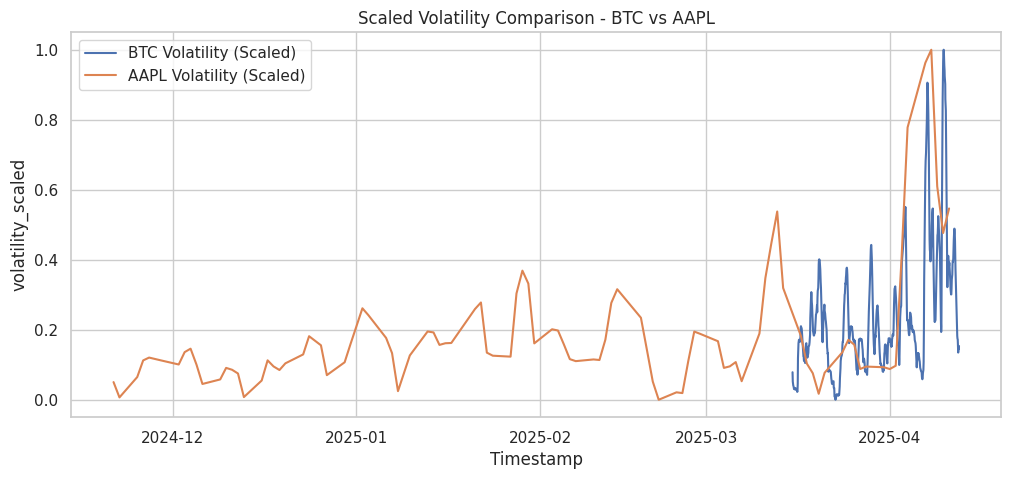

In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
btc["volatility_scaled"] = scaler.fit_transform(btc[["volatility"]])
aapl["volatility_scaled"] = scaler.fit_transform(aapl[["volatility"]])

plt.figure(figsize=(12, 5))
sns.lineplot(data=btc, x="Timestamp", y="volatility_scaled", label="BTC Volatility (Scaled)")
sns.lineplot(data=aapl, x="Date", y="volatility_scaled", label="AAPL Volatility (Scaled)")
plt.title("Scaled Volatility Comparison - BTC vs AAPL")
plt.show()



### Q4 Answer: Crypto vs Stock Behavior Under Market Conditions

The dual-axis plot clearly shows that BTC is more volatile than AAPL. BTC exhibits large swings day-to-day, while AAPL’s volatility is more stable and lower in scale. This supports the idea that crypto assets carry higher risk and reward under similar market trends.

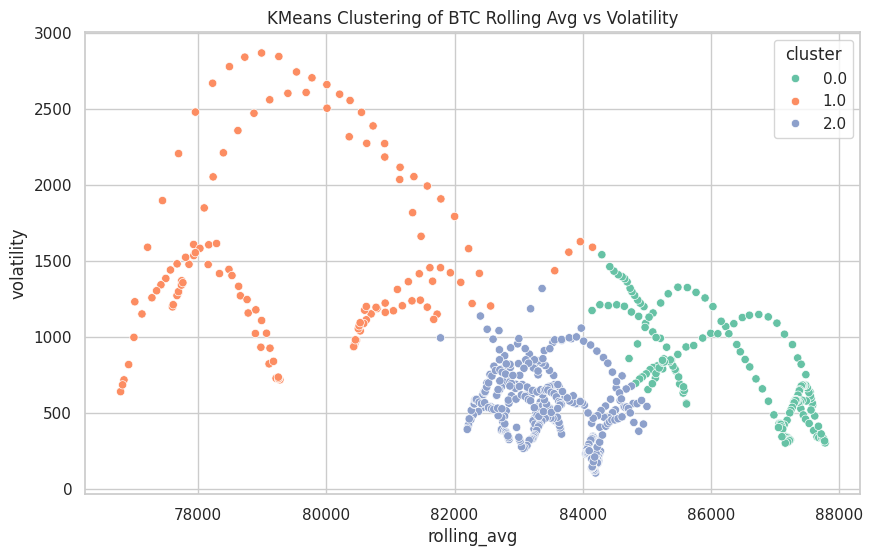

In [19]:
# BONUS: KMeans Clustering on BTC to identify behavior patterns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

features = btc[["rolling_avg", "volatility"]].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=3, random_state=42)
btc.loc[features.index, "cluster"] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=btc, x="rolling_avg", y="volatility", hue="cluster", palette="Set2")
plt.title("KMeans Clustering of BTC Rolling Avg vs Volatility")
plt.show()


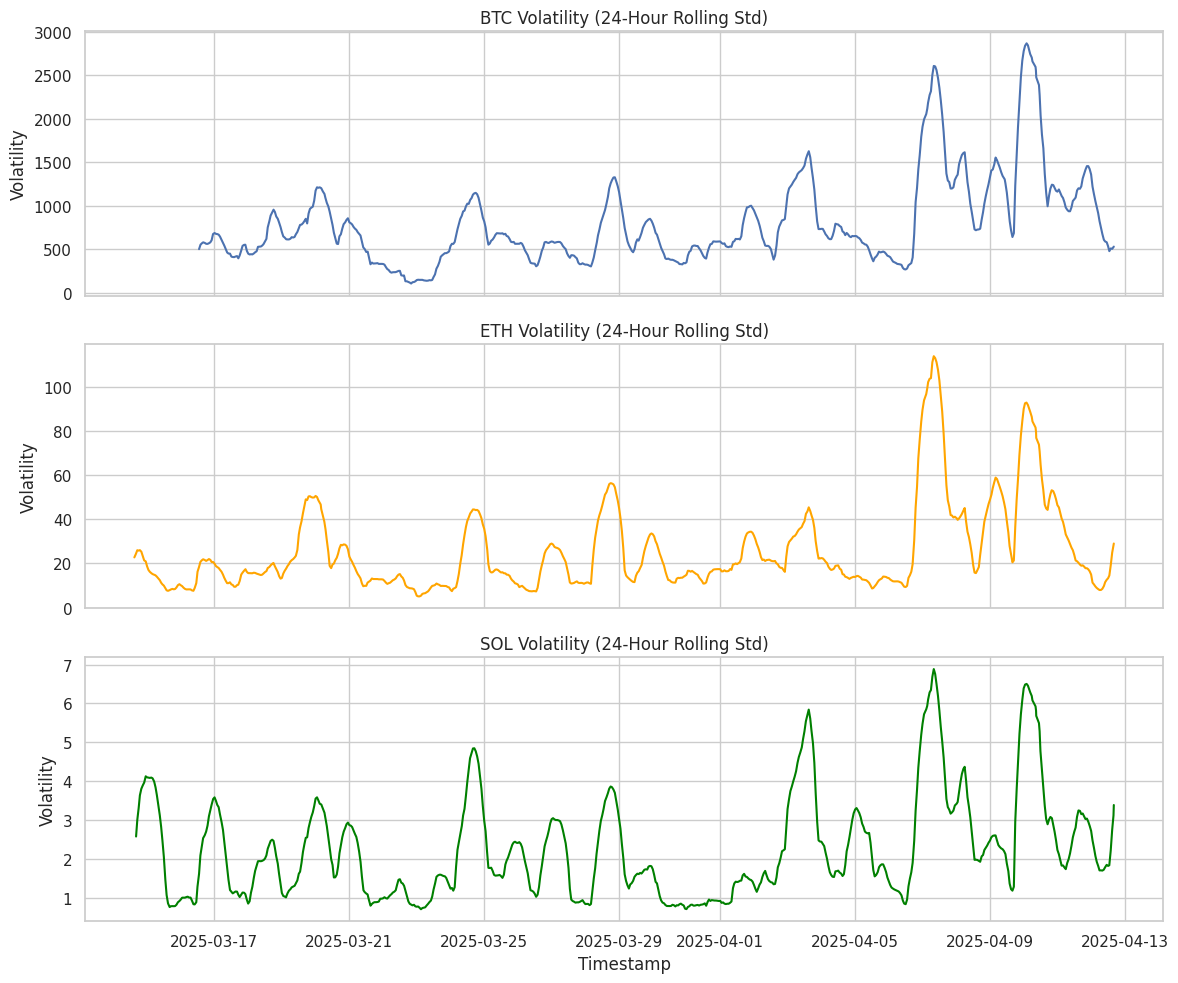

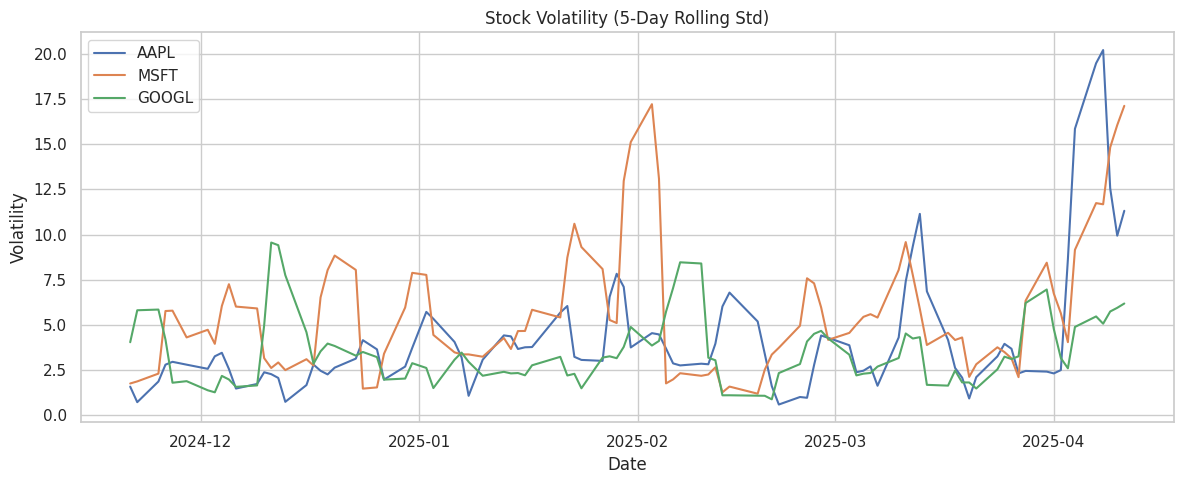

In [30]:
# Volatility Calculations
btc["volatility"] = btc["Price"].rolling(window=24).std()
eth["volatility"] = eth["Price"].rolling(window=24).std()
sol["volatility"] = sol["Price"].rolling(window=24).std()

aapl["volatility"] = aapl["Close"].rolling(window=5).std()
msft["volatility"] = msft["Close"].rolling(window=5).std()
googl["volatility"] = googl["Close"].rolling(window=5).std()

# Subplots for Crypto Volatility
fig, axs = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

sns.lineplot(data=btc, x="Timestamp", y="volatility", ax=axs[0])
axs[0].set_title("BTC Volatility (24-Hour Rolling Std)")
axs[0].set_ylabel("Volatility")

sns.lineplot(data=eth, x="Timestamp", y="volatility", ax=axs[1], color="orange")
axs[1].set_title("ETH Volatility (24-Hour Rolling Std)")
axs[1].set_ylabel("Volatility")

sns.lineplot(data=sol, x="Timestamp", y="volatility", ax=axs[2], color="green")
axs[2].set_title("SOL Volatility (24-Hour Rolling Std)")
axs[2].set_ylabel("Volatility")

plt.xlabel("Timestamp")
plt.tight_layout()
plt.show()


# Plotting Stock Volatility
plt.figure(figsize=(12, 5))
sns.lineplot(data=aapl, x="Date", y="volatility", label="AAPL")
sns.lineplot(data=msft, x="Date", y="volatility", label="MSFT")
sns.lineplot(data=googl, x="Date", y="volatility", label="GOOGL")
plt.title("Stock Volatility (5-Day Rolling Std)")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.legend()
plt.tight_layout()
plt.show()

